## Import all Libraries

In [1]:
# AWS Rekognition to get bbox
import numpy as np
import boto3
from PIL import Image, ImageDraw, ExifTags, ImageColor, ImageFont
from matplotlib import pyplot as plt
from utils.rekognition import determine_color, draw_animal_count
import time
import math
import os
import glob
import io
import json
FNT = ImageFont.truetype('/usr/share/fonts/default/Type1/n019004l.pfb', 25)

## Get Bounding Boxes from Video Frames

In [2]:
#draw response
def draw_response(image, response, animal_target):
    # original image size
    draw = ImageDraw.Draw(image)

    for customLabel in response['CustomLabels']:

        if 'Geometry' in customLabel:
            box = customLabel['Geometry']['BoundingBox']
            left = box['Left']
            top = box['Top']
            width = box['Width']
            height = box['Height']
            #print(customLabel['Name'])
            label = customLabel['Name']
        
            text = label
            text_width, text_height = FNT.getsize(label)
            color = determine_color(label, True)

            button_width = int(text_width + 20)
            button_height = int(text_height + 15)
            button_size = (button_width, button_height)
            button_img = Image.new('RGB', button_size, color)
            button_draw = ImageDraw.Draw(button_img)
            button_draw.text((10, 10), text, fill ='#000000', font=FNT)
            image.paste(button_img, (int(left), int(top)))  

            points = (
                (left, top),
                (left + width, top),
                (left + width, top + height),
                (left , top + height),
                (left, top))
            
            thickness = 5
            
            if label == 'cow':
                thickness = 7
                
            draw.line(points, fill=color, width=thickness)
    
    img = np.asarray(image)[:,:,::-1].copy()
    return img

In [3]:
def get_bbox_json(src_file, output_file, projectVersionArn, min_confidence=75):
    start = time.time()
    rekognition = boto3.client('rekognition')
    count = 0
    # get total frames
    frame_total = 0
    for infile in os.listdir(src_file):
        if infile.endswith(".jpg"):
            frame_total += 1
    print('Total frames:', frame_total)
    frame_res = [{} for _ in range(frame_total)]
    # process each image file
    for infile in os.listdir(src_file):
        if infile.endswith(".jpg"):
            file, ext = os.path.splitext(infile)
            frameId = int(file)
            #print('FrameId', frameId)
            with Image.open(src_file+file+ext) as img:
                #print(img.size)
                img_byte_arr = io.BytesIO()
                img.save(img_byte_arr, format='PNG')
                img_byte_arr = img_byte_arr.getvalue()
                # get labels
                response = rekognition.detect_custom_labels(
                    Image={
                        'Bytes': img_byte_arr,
                    },
                    MinConfidence=min_confidence,
                    ProjectVersionArn=projectVersionArn
                )
                imgWidth, imgHeight = img.size
                # scale bbox coordiantion to image size 
                for idx, customLabel in enumerate(response['CustomLabels']):
                    if 'Geometry' in customLabel:
                        box = customLabel['Geometry']['BoundingBox']
                        box['Left'] = imgWidth * box['Left']
                        box['Top'] = imgHeight * box['Top']
                        box['Width'] = imgWidth * box['Width']
                        box['Height'] = imgHeight * box['Height']
                if frameId == 200:
                    inferred_frame = draw_response(img, response, animal_target='cow')
                    plt.imshow(inferred_frame)
                    plt.title("Frame {}".format(int(frameId)))
                    plt.show()
                frame_res[frameId] = {'CustomLabels': response['CustomLabels']}
                    
            count+=1
            if count % 50 == 0:
                print("Finish Processing {} frame".format(count))
                lap = time.time()
                print('lap time: ', lap - start)
                
    #print(frame_res[617])
    #the json file where the output must be stored
    with open(output_file, 'w+') as out_file:
        json.dump({'Frames':frame_res}, out_file)
        out_file.close()
    end = time.time()
    print('total time lapse', end - start)

frame_img/IMG_4195/
json_data/IMG_4195_bbox.json
Total frames: 1070
Finish Processing 50 frame
lap time:  175.10181140899658
Finish Processing 100 frame
lap time:  346.0411500930786
Finish Processing 150 frame
lap time:  519.9830868244171
Finish Processing 200 frame
lap time:  692.2219846248627
Finish Processing 250 frame
lap time:  864.3959329128265
Finish Processing 300 frame
lap time:  1036.9815843105316
Finish Processing 350 frame
lap time:  1209.5877885818481
Finish Processing 400 frame
lap time:  1381.6674513816833
Finish Processing 450 frame
lap time:  1553.6792199611664


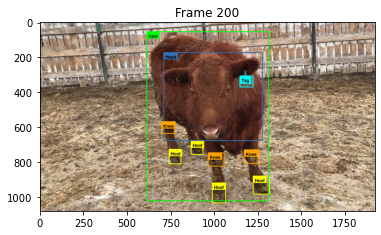

Finish Processing 500 frame
lap time:  1724.8537106513977
Finish Processing 550 frame
lap time:  1897.4374508857727
Finish Processing 600 frame
lap time:  2072.405590057373
Finish Processing 650 frame
lap time:  2247.878798723221
Finish Processing 700 frame
lap time:  2421.39271736145
Finish Processing 750 frame
lap time:  2593.688416004181
Finish Processing 800 frame
lap time:  2764.960098028183
Finish Processing 850 frame
lap time:  2938.799978017807
Finish Processing 900 frame
lap time:  3109.718591451645
Finish Processing 950 frame
lap time:  3280.921410560608
Finish Processing 1000 frame
lap time:  3452.712683916092
Finish Processing 1050 frame
lap time:  3623.5953934192657
total time lapse 3692.5963118076324
finished estimating bbox.


In [6]:
six_class_arn = 'arn:aws:rekognition:us-east-1:617989056061:project/cow-detector/version/cow-detector.2021-05-11T13.23.57/1620764637425'
# 'Maternity Pen 1_00_20210420044929', 'Maternity Pen 1_00_20210420044420', 'Maternity Pen 1_00_20210420044503'
#, 'cattle_multi_1', 'cattle_single_1' 
video_name_list = ['IMG_4195']
for video_name in video_name_list:
    src_path = 'frame_img/'+video_name+'/'
    output_json_path = 'json_data/'+video_name+'_bbox.json'
#     if not os.path.exists(output_json_path):
#         os.makedirs(output_json_path)
    print(src_path)
    print(output_json_path)
    get_bbox_json(src_path, output_json_path, six_class_arn)
print('finished estimating bbox.')